# Data Sampling
## A/B Testing

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Import libraries
from __future__ import absolute_import, division, print_function

# Ignore warnings
import warnings
#warnings.filterwarnings('ignore')

import sys
sys.path.append('tools/')

import numpy as np
import pandas as pd
import scipy.stats as st

# Graphing Libraries
import matplotlib.pyplot as pyplt
import seaborn as sns
sns.set_style("white")  

# Configure for presentation
np.set_printoptions(threshold=50, linewidth=50)
import matplotlib as mpl
mpl.rc('font', size=16)

from IPython.display import display

In [4]:
def axis_tick_frequency(ax, axis, freq):
    """The frequency of the y axis tick marks
        Attributes
        ----------
        ax: matplotlib axis object
        axis: char eithher 'y' or 'x'
        freq: int, the integer value of which the range moves
    """
    
    if axis == 'y':
        start, end = ax.get_ylim()
        ax.yaxis.set_ticks(np.arange(start, end, freq))
    elif axis == 'x':
        start, end = ax.get_xlim()
        ax.xaxis.set_ticks(np.arange(start, end, freq))
    else:
        raise ValueError('{argument} is not a valid axis object'.format(argument=repr(axis)))

In [5]:
def sample(num_sample, top, with_replacement=False):
    """
    Create a random sample from a table
    
    Attributes
    ---------
    num_sample: int
    top: dataframe
    with_replacement: boolean
    
    Returns a random subset of table index
    """
    df_index = []
    lst = np.arange(0, len(top), 1)

    for i in np.arange(0, num_sample, 1):

        # pick randomly from the whole table
        sample_index = np.random.choice(lst)

        if with_replacement:
            # store index
            df_index.append(sample_index)
        else:
            # remove the choice that was selected
            lst = np.setdiff1d(lst,[sample_index])
            df_index.append(sample_index)
            
    return df_index


## Smokers and Nonsmokers

Many different analyses has been performed on this random sample of mothers and their newborn infants, but not an analysis looking at the data whether the mothers smoked. One of the aims of the study was to see whether maternal smoking was associated with birth weight.

In [6]:
baby_df = pd.read_csv('data/baby.csv')

In [7]:
baby_df.head()

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
0,120,284,27,62,100,False
1,113,282,33,64,135,False
2,128,279,28,64,115,True
3,108,282,23,67,125,True
4,136,286,25,62,93,False


In [8]:
weight_smoke = baby_df[['Birth Weight', 'Maternal Smoker']]

In [9]:
weight_smoke['Maternal Smoker'].value_counts()

False    715
True     459
Name: Maternal Smoker, dtype: int64

The histogram below displays the distribution of birth weights of the babies of the non-smokers and smokers in the sample. 

In [10]:
smoker = baby_df['Maternal Smoker'] == True
non_smoker = baby_df['Maternal Smoker'] == False

df_non_smoker = baby_df.ix[baby_df[non_smoker].index, :]
df_non_smoker.columns = [u'Non Smoker Birth Weight', u'Gestational Days', u'Maternal Age',
       u'Maternal Height', u'Maternal Pregnancy Weight', u'Maternal Smoker']

df_smoker = baby_df.ix[baby_df[smoker].index, :]
df_smoker.columns = [u'Smoker Birth Weight', u'Gestational Days', u'Maternal Age',
       u'Maternal Height', u'Maternal Pregnancy Weight', u'Maternal Smoker']

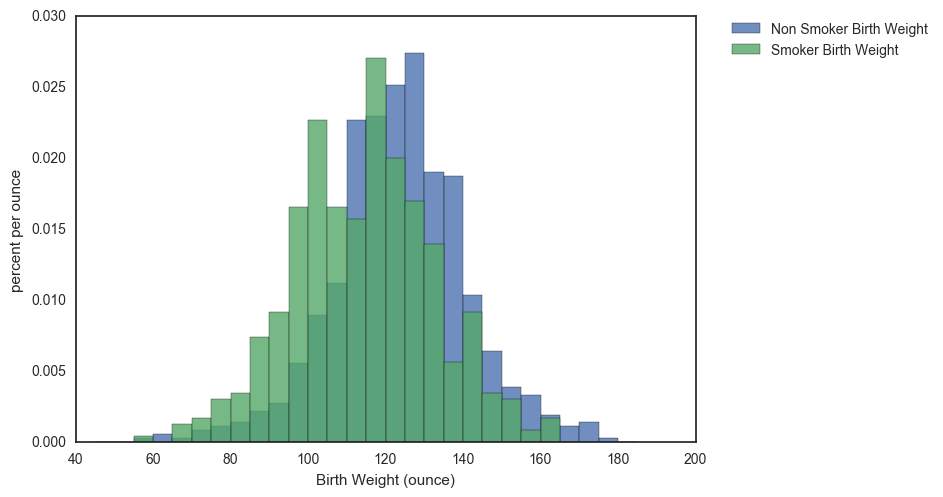

In [11]:
df_non_smoker['Non Smoker Birth Weight'].plot.hist(bins=np.arange(40, 186, 5), normed=True, alpha = 0.8)
df_smoker['Smoker Birth Weight'].plot.hist(bins=np.arange(40, 186, 5), normed=True, alpha = 0.8)
pyplt.ylabel("percent per ounce")
pyplt.xlabel("Birth Weight (ounce)")
pyplt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

Both distributions are approximately bell shaped and centered near 120 ounces. The distributions are not identical, of course, which raises the question of whether the difference reflects just chance variation or a difference in the distributions in the population.

**Null hypothesis**: In the population, the distribution of birth weights of babies is the same for mothers who don't smoke as for mothers who do. The difference in the sample is due to chance.        
**Alternative hypothesis**: The two distributions are different in the population.          
**Test statistic**: T test 

Alternatively, we could use:     
**Test statistic**: Birth weight is a quantitative variable, so it is reasonable to use the absolute difference between the means as the test statistic.
The observed value of the test statistic is about 9.27 ounces.

In [74]:
a = df_non_smoker['Non Smoker Birth Weight'].values
b = df_smoker['Smoker Birth Weight'].values

In [49]:
# difference in the means
a.mean() - b.mean()

9.2661425720249184

In [56]:
raw = {
        'Maternal Smoker': [False, True],
        'Birth Weight mean': [123.085, 113.819]
}
means_table = pd.DataFrame(raw)
means_table

,Birth Weight mean,Maternal Smoker
0,123.085,False
1,113.819,True


In [36]:
statistic, pvalue = st.ttest_ind(a, b)
print ('T statistic: %.2f'%statistic,'\nP-value:%.2f'%pvalue)


T statistic: 8.72 
P-value:0.00


The **P-value** is very, very small. As a result, we can *reject* the null hypothesis and conclude that in the population, the distribution of birth weights for babies of mothers who smoke and those that don't smoke are different.

### Bootstrap Confidence Interval For the Difference

Our A/B test has concluded that the two distributions are different, but that's a little unsatisfactory. 
- How different are they? 
- Which one has the larger mean? 

These are natural questions that the test can't answer. Instead of just asking a yes/no question about whether the two distributions are different, we might learn more by not making any hypotheses and simply estimating the difference between the means.

The observed difference (nonsmokers  −−  smokers) was about **9.27 ounces**.
- **The positive sign** says that the non-smoking mothers had larger babies on average. 

But samples could have come out differently due to randomness. To see how different, we have to generate more samples; to generate more samples, we'll use the bootstrap. The bootstrap makes no hypotheses about whether or not the two distributions are the same. It simply replicates the original random sample and computes new values of the statistic.

The function `bootstrap_ci_means` returns a bootstrap confidence interval for the **difference between the means** of the two groups in the population. In our example, the confidence interval would estimate the difference between the average birth weights of babies of mothers who didn't smoke and mothers who did, in the entire population.

The function returns an approximate 95% confidence interval for the difference between the two means, using the bootstrap percentile method.

In [32]:
import scikits.bootstrap as bootstrap  
import scipy

In [31]:
# compute 95% confidence intervals around the mean  

CIs = bootstrap.ci(baby_df[['Birth Weight', 'Maternal Smoker']], scipy.mean) 
print ("Bootstrapped 95% confidence interval around the mean\nLow:",  CIs[0], "\nHigh:", CIs[1]) 

Bootstrapped 95% confidence interval around the mean
Low: 59.3977853492 
High: 60.4603918228


In [58]:
# bootstrap 5000 samples instead of only 1174  
CIs = bootstrap.ci(baby_df[['Birth Weight', 'Maternal Smoker']], scipy.mean, n_samples=5000)  

print ("Bootstrapped 95% confidence interval with 5,000 samples\nLow:",  CIs[0], "\nHigh:", CIs[1]) 

Bootstrapped 95% confidence interval with 5,000 samples
Low: 59.41439523 
High: 60.4706132879


In [181]:
def get_means(df, variable, classes):
    """
    Gets the means of a variable grouped by its class
    
    Attributes
    -------------
    df: a pandas dataframe
    variable: column
    classes: column (bool) 
    """
    class_a = df[classes] == True
    class_b = df[classes] == False

    df_class_b = df.ix[df[class_b].index, :]
    df_class_a = df.ix[df[class_a].index, :]

    a = df_class_b[variable].values
    b = df_class_a[variable].values
    
    # difference in the means
    a.mean() - b.mean()
    
    raw = {
        classes: [False, True],
        variable: [a.mean(), b.mean()]
    }
    means_table = pd.DataFrame(raw)
    
    return means_table
    

In [186]:
def bootstrap_ci_means(table, variable, classes, repetitions):

    """Bootstrap approximate 95% confidence interval
    for the difference between the means of the two classes
    in the population
    
    Attributes
    -------------
    table: a pandas dataframe
    variable: column
    classes: column (bool) 
    repetitions: int
    """

    t = table[[variable, classes]]

    mean_diffs = []
    for i in np.arange(repetitions):
        bootstrap_sampl = table.ix[sample(len(table), table, with_replacement=True), :]
        m_tbl = get_means(bootstrap_sampl, variable, classes)
        new_stat = m_tbl.ix[0, variable] - m_tbl.ix[1, variable]
        mean_diffs = np.append(mean_diffs, new_stat)

    left = np.percentile(mean_diffs, 2.5) 
    right = np.percentile(mean_diffs, 97.5)

    # Find the observed test statistic
    means_table = get_means(t, variable, classes)
    obs_stat = means_table.ix[0, variable] - means_table.ix[1, variable]

    df = pd.DataFrame()
    df['Difference Between Means'] = mean_diffs
    df.plot.hist(bins=20, normed=True)
    plot([left, right], [0, 0], color='yellow', lw=8);
    print('Observed difference between means:', obs_stat)
    print('Approximate 95% CI for the difference between means:')
    print(left, 'to', right)

Observed difference between means: 9.26614257202
Approximate 95% CI for the difference between means:
5.86365068063 to 12.828668629


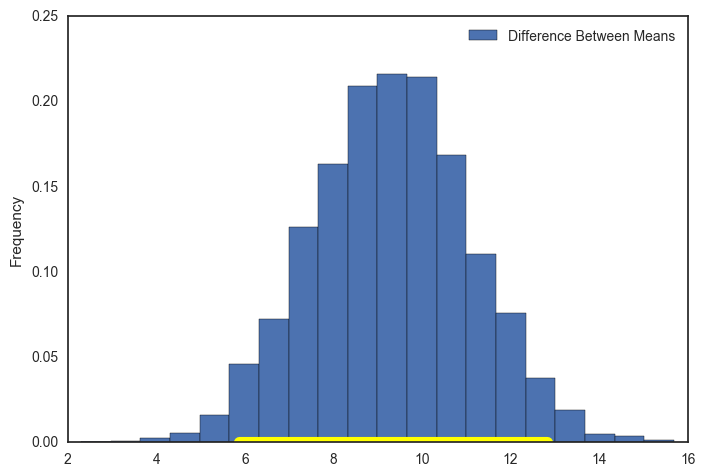

In [187]:
bootstrap_ci_means(baby_df, 'Birth Weight', 'Maternal Smoker', 5000)

This bootstrapped confidence interval tells us that on average *non-smoking* mothers had babies that weighed between 5.8 to 12.8 ounces larger than their smoking counter parts. Furthermore, because 0 is not included in the confidence interval between the difference in the means, we can tell that this distributions are different.

Observed difference between means: 0.80767250179
Approximate 95% CI for the difference between means:
-0.309530696732 to 1.908354003


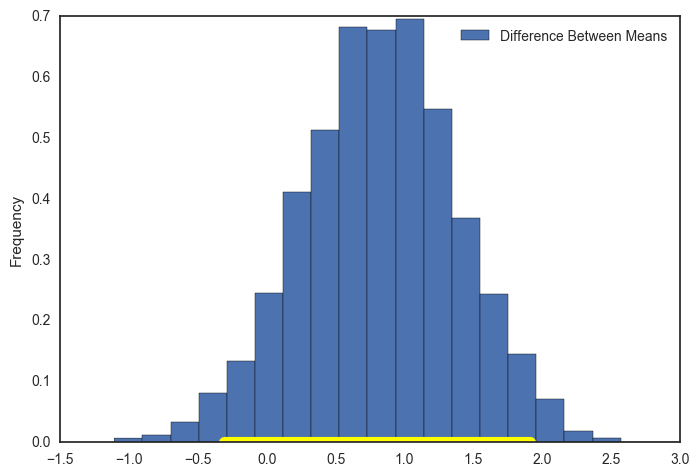

In [191]:
bootstrap_ci_means(baby_df, 'Maternal Age', 'Maternal Smoker', 5000)

In this case, the distributions are the same. Maternal age and smoking have no effect on babies birth weight. We know this because 0 is in the confidence interval.